# hubble network

In [572]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import os
%matplotlib inline

In [573]:
def read_einstein():
    with open('allFellowsList.html') as handle:
        page = handle.read()
        years = page.split('<tr><th>')[1:]
        years[-1]=years[-1].split('</table>')[0]

        fellows = np.concatenate([parse_einstein_year(year) for year in years[:]],dtype='U10000')
        ## deal with the fermi fellows, all like 4 of them
        index = np.argwhere(fellows[:,-2]=='')[0,0]
        fermi_year = fellows[index,0]
        fellowtype = fellows[index,-3].split('>')[1].split(' ')[0]
        index+=1
        while fellows[index,0] == fermi_year:
            fellows[index,1] = fellowtype
            index+=1
        fellows = fellows[fellows[:,-1]!='']
        ## append the 2 institutions people (all two of them)
        for index in np.argwhere(fellows[:,1]=='')[:,0]: fellows[index-1][-1]+=' ; '+fellows[index][-1]
        fellows = fellows[fellows[:,-2]!='']
        
    return fellows

def parse_einstein_year(blob):
    blob=blob.replace('<tr>','').replace('<td>','').replace('</td></tr>','').replace('\t','').replace('  ','')
    blob = blob.split('<TR>')[0]
    year = blob[:4]
    fellows = blob.split('\n')[1:]
    fellowtype = fellows[0].split('>')[1].split(' ')[0]
    fellows = fellows[1:]
    fellows = [[year,fellowtype]+fellow.split('</td>')+['N/A'] for fellow in fellows if len(fellow)]
    return fellows
    

einstein_fellows = read_einstein()
#einstein_fellows

In [574]:
def read_sagan():
    fellows = [ parse_sagan_year(fname) for fname in sorted(os.listdir('sagan')) if 'sw' not in fname] 
    return np.concatenate(fellows,dtype='U10000')
        
def parse_sagan_year(fname):

    year = fname[:4]
    with open(os.path.join('sagan',fname)) as handle:
        blob = handle.read().split('footer')[0].split('Postdoctoral Fellowship Recipients')
        fellowtype=blob[0][-100:].split('\n')[-1].strip()
        blob = blob[1]
        postdocs = blob.split('panel')[2].strip().split('<h5>')[1:]
        #print(year,fellowtype,len(postdocs))
        postdocs = [[year,fellowtype] + parse_sagan_postdoc(postdoc) for postdoc in postdocs]
        #print('--------------------------------------------------------')
    return postdocs

    
def parse_sagan_postdoc(postdoc):
    name = postdoc.split('</h5>')[0].strip()
    location,abstract = postdoc.split('<h6>')[1].split('</h6>')
    location = location.strip()
    abstract = '\n'.join(abstract.split('</p>')[:-1]).replace('<p>','').strip().replace('  ','').replace('\n\n','\n')
    return [name,location,abstract]



sagan_fellows = read_sagan()

#sagan_fellows[:,:-1]

In [609]:
def read_hubble():

    fellows_pre17 = parse_hubble_pre17()
    fellows_post17 = parse_hubble_post17()

    return np.concatenate(fellows_pre17[::-1]+fellows_post17,dtype='U10000')

def parse_hubble_pre17():

    with open('2017-and-prior-fellows','r') as handle:
        blob = handle.read()
        years = blob.split('<section id=')[4:]

    return [parse_hubble_pre17_year(year) for year in years]

def parse_hubble_pre17_year(blob):
    year = blob.split('data-name="section-')[1].split('class')[0].strip()[:-1]
    fellowtype='Hubble'
    fellows = blob.split('<tbody>')[1].replace('\n','').replace('\t','').replace('</tr>','').replace('</td>','').split('<tr>')[1:]

    return [[year,fellowtype]+parse_hubble_pre17_fellow(fellow) for fellow in fellows]

def parse_hubble_pre17_fellow(fellow):
    name,src,dst = fellow.split('<td>')[1:]

    ## sometimes they have /tbodys in them??
    dst = dst.split('</tbody>')[0]

    if '<' in dst: 
        print(dst)
        import pdb; pdb.set_trace()

    ## name, destination, and "abstract"
    return [name,dst,f'Came from: {src}. N/A']

def parse_hubble_post17():
    return [parse_hubble_post17_year(fname) for fname in sorted(os.listdir('hubble')) if '.sw' not in fname]

def parse_hubble_post17_year(fname):
    with open(os.path.join('hubble',fname),'r') as handle:
        year = fname[:4]
        fellows = handle.read().split('main-content')[2].split('<section id=')[2:]
    
    return [[year]+parse_hubble_post17_fellow(fellow) for fellow in fellows]

def parse_hubble_post17_fellow(blob):
    blob = blob.replace('\n','').replace('\t','').replace('  ','').replace('</p>','').replace('</section>','').replace('&nbsp;','')
    ## remove the footer
    blob = blob.split('<div class="credits dark-background-stsci-dark-blue">')[0]

    ## get the name
    name = blob.split('</h2>')[0][-100:].split('>')[1]

    ## seek to the name in the blob
    blob = blob[blob.index(name)+len(name):].replace('</div>','').split('Fellow')
    fellowtype,blob = blob[0],'Fellow'.join(blob[1:])
    fellowtype = fellowtype.split('>')[-1]

    blob = blob.split(r'Host Institution:')[1]

    ## [6:] at the end to get rid of &nbsp;
    dst = blob.split('<p>')[0].strip()[len('</strong>'):].strip()
    if '&nbsp;' in dst: dst = dst[len('&nbsp;'):]

    abstract = blob.split('<p>')[1:]
    abstract = '\n'.join(abstract)

    #print(abstract)
    #print('-----------------')

    return [fellowtype,name,dst,abstract]



hubble_fellows = read_hubble()

hubble_fellows[:,:-1]

array([['1990', 'Hubble', 'Pawel Artymowicz',
        'University of California, Santa Cruz'],
       ['1990', 'Hubble', 'Stefi Baum', 'Johns Hopkins University'],
       ['1990', 'Hubble', 'Michael Bolte',
        'University of California, Santa Cruz'],
       ...,
       ['2022', 'Einstein ', 'David Vartanyan', 'Carnegie Observatories'],
       ['2022', 'Sagan ', 'Michael Wong',
        'Carnegie Earth and Planets Laboratory'],
       ['2022', 'Sagan ', 'Zhoujian Zhang',
        'University of California, Santa Cruz']], dtype='<U10000')

In [610]:
nsf_fellows = np.load('../2022-07-30-NSF_AAPF_map_viz/nsf_fellows.npy').astype('U10000')
#nsf_fellows

In [611]:
def clean_locations(fellows):
    locations = fellows[:,-2]
    for i in range(len(locations)):
        location = locations[i]
        fellows[i,-2] = clean_location(location)

## this is going to be ugly
def clean_location(location):
    cfa = 'Harvard-Smithsonian Center for Astrophysics'
    location = location.strip()
    location = location.replace('CalTech','California Institute of Technology')
    location = location.replace('Caltech','California Institute of Technology')
    location = location.replace('Institue','Institute')
    location = location.replace(' in New York City','')
    location = location.replace(' universities','')
    location = location.replace('and at','and')
    location = location.replace(
        'Kavli Institute for Theoretical Physics at University of California, Santa Barbara,',
        'University of California, Santa Barbara')
    location = location.replace('and then at','and')
    location = location.replace(
        'Harvard-Smithsonian Center for Astrophysics, NRAO - Charlottesville, and University of Virginia',
        'Harvard-Smithsonian Center for Astrophysics and NRAO - Charlottesville and University of Virginia',)
    location = location.replace(
        'Center for Astrophysics',
        'Harvard-Smithsonian Center for Astrophysics')
    location = location.replace(
        'Harvard-Smithsonian Harvard-Smithsonian',
        'Harvard-Smithsonian')
    location = location.replace(' at Harvard University','')
    location = location.replace(' (CfA)','')
    location = location.replace(
        'Harvard College Observatory',
        'Harvard-Smithsonian Center for Astrophysics')
    location = location.replace( 'Harvard University',cfa)
    location = location.replace(
        'Harvard College Observatories',
        'Harvard-Smithsonian Center for Astrophysics')
    location = location.replace(' &ndash; Tucson','')
    location = location.replace(
        'National Optical Astronomical Observatories','National Optical Astronomical Observatory')
    location = location.replace('UCO/','')
    location = location.replace('Unversity','')
    location = location.replace(
        'Institute for Theoretical Physics at University of California, Santa Barbara',
        'University of California, Santa Barbara')
    location = location.replace(' in New Haven, Connecticut','')
    location = location.replace('Case Western University','Case Western Reserve University')

    if location == 'Smithsonian Astrophysical Observatory': location = cfa

    if location == 'Princeton University Center for Theoretical Science': location = 'Princeton University'

    location = location.replace('Urbana- ','Urbana-')
    
    ## conditionals
    if location == 'Cerro Tololo InterAmerican Observatory (CTIO) of National Optical Astronomy Observatories (NOAO), in La Serena, Chile':
        location = 'Cerro Tololo InterAmerican Observatory'
    

    if ('Carnegie Instit' in location and 'Obs' not in location or
        'Carnegie Earth and Planets Laboratory' == location or
        'Department of Terrestrial Magnetism' in location):
        location = 'Carnegie Institute of Washington'

    mit = 'Massachusetts Institute of Technology'
    if mit in location and 'Kavli' in location: location = mit

    uoa = 'University of Arizona'
    if uoa in location: location = uoa

    cwru = 'Case Western Reserve University'
    if 'CWRU' in location: location = cwru

    if 'Virginia' in location and 'National Radio Astronomy Observatory' in location: 
        location = location.replace('National Radio Astronomy Observatory','NRAO - Charlottesville')
    if 'National Radio Astronomy Observatory' in location and 'Socorro' in location: 
        location = location.replace('National Radio Astronomy Observatory at Socorro','NRAO - Socorro')
        location = location.replace('National Radio Astronomy Observatory in Socorro','NRAO - Socorro')
    
    lasp = 'Laboratory for Atmospheric and Space Physics (LASP) at '
    if lasp in location: location = location.replace(lasp,'')

    if 'RIT' in location: location = 'Rochester Institute of Technology'

    if ' and ' in location: location = location.replace(' and ','; ')

    if 'Center for Adaptive Optics ' in location: location  = 'University of California, Santa Cruz'

    if '/' in location and 'Chicago' in location: location = location.split('/')[0]

    location = location.replace('/','; ')

    if 'University of Chicago' in location and 'Cosmological' in location: location = 'University of Chicago'

    location = location.replace('Cornell;','Cornell University;')
    location = location.replace('Princeton','Princeton University')

    if location == 'Harvard-Smithsonian Center for Astrophysics, NRAO - Charlottesville,; University of Virginia':
        location = 'Harvard-Smithsonian Center for Astrophysics; NRAO - Charlottesville; University of Virginia'

    if location == 'High Altitude Observatory of National Center for Atmospheric Research in Boulder, Colorado':
        'High Altitude Observatory of National Center for Atmospheric Research in Boulder, Colorado'
    
    if 'Boulder' in location: location ='University of Colorado, Boulder'

    if 'Hawaii' in location: location = 'University of Hawaii, Institute for Astronomy'

    if 'Institute for Advanced' in location: location = 'Princeton University'
    if 'Institute of Advanced' in location: location = 'Princeton University'
    if 'Lawrence Berk' in location: location = 'Lawrence Berkeley National Laboratory'

    location = location.replace('NASA Ames','NASA Ames Research Center')
    location = location.replace('NASA Ames NASA Ames','NASA Ames')
    location = location.replace('Research Center Research Center','Research Center')

    while '(' in location:
        index = location.index('(')
        findex = location[index+1:].index(')')
        location = location[:index-1] + location[index+findex+2:]
    
    location = location.replace('University of California-','University of California, ')
    location = location.replace('University of California at','University of California,')
    location = location.replace('University of California ','University of California, ')

    if 'University of California, Irvine' in location: location = 'University of California, Irvine'


    location = location.replace('KITP-UCSB','University of California, Santa Barbara')
    if location == 'Northwestern University; University of California, Santa': location += ' Barbara'

    if 'University of Massachusetts' in location: location = 'University of Massachusetts, Amherst'

    if 'Yale' in location: location = location.replace('Yale','Yale University')
    
    if 'Madison' in location: location = 'University of Wisconsin, Madison'

    if 'Observatories' in location and 'Carnegie' in location: location = 'Carnegie Observatories'

    if 'MIT' in location: location = mit
    
    location = location.replace('National Optical Astronomical Observatory','National Optical Astronomy Observatory')

    location = location.replace('The ','')

    if 'University of Texas' in location: location = 'University of Texas, Austin'
    if 'University of Wisconsin' in location: location = 'University of Wisconsin, Madison'

    if 'University of Illinois' in location: location = 'University of Illinois, Urbana-Champaign'
    if 'University of Colorado' in location: location = 'University of Colorado, Boulder'
    if 'University of Maryland' in location: location = 'University of Maryland, College Park'

    location = location.replace('Angles','Angeles')

    location = location.replace('Boston University of','Boston University')

    if 'Rutgers' in location: location = 'Rutgers University'

    if 'Accelerator' in location: location = 'SLAC National Laboratory'


    location = location.replace('State University of','State University')

    location = location.replace('University University','University')
    location = location.strip()
    return location

In [625]:
locations = set([])
total = 0
all_locs = []
for j,fellows in enumerate([hubble_fellows,nsf_fellows,einstein_fellows,sagan_fellows]):
    total += len(fellows)
    clean_locations(fellows)
    these_locs = np.hstack([fellow.split('; ') for fellow in fellows[:,-2]])
    for i,loc in enumerate(these_locs):
        if 'Northwestern' in loc and 'California' in loc: print(j,i,loc)
    locations = locations.union(set(these_locs))
    all_locs = np.append(all_locs,these_locs,axis=0)
print(total,len(locations))

919 83


In [ ]:
all_fellows = np.concatenate([hubble_fellows,nsf_fellows,einstein_fellows,sagan_fellows])

In [629]:
unique_locs = np.unique(all_locs)

In [631]:
hists = np.zeros(unique_locs.shape[0])
for i,loc in enumerate(unique_locs):
    hists[i] = np.sum(all_locs==loc)

In [634]:
sort_indices = np.argsort(hists)
unique_locs[sort_indices][::-1]

array(['Harvard-Smithsonian Center for Astrophysics',
       'Princeton University', 'California Institute of Technology',
       'University of California, Berkeley',
       'Massachusetts Institute of Technology', 'University of Arizona',
       'Carnegie Observatories', 'University of California, Santa Cruz',
       'University of Chicago', 'University of Texas, Austin',
       'University of Colorado, Boulder',
       'University of Hawaii, Institute for Astronomy',
       'Columbia University', 'Johns Hopkins University',
       'Yale University', 'University of Michigan',
       'University of Washington',
       'Lawrence Berkeley National Laboratory', 'Stanford University',
       'Carnegie Institute of Washington',
       'University of Wisconsin, Madison',
       'University of California, Santa Barbara',
       'Space Telescope Science Institute',
       'University of California, Los Angeles', 'Northwestern University',
       'Jet Propulsion Laboratory',
       'University

In [888]:
import pandas as pd
"""
nrow = ncol = int(np.round(np.sqrt(unique_locs.shape[0]))+1)
X,Y = np.meshgrid(np.linspace(0,1,nrow),np.linspace(0,1,ncol))
xs = X.flatten()[:unique_locs.shape[0]]*2
ys = Y.flatten()[:unique_locs.shape[0]]*2
xs -= np.mean(xs)
ys -= np.mean(ys)
"""
data_dict = dict(
    location=unique_locs[sort_indices][::-1],
    size=hists[sort_indices][::-1],
)
data_df = pd.DataFrame(data_dict)

In [904]:
data_dict['location'][0]

'Harvard-Smithsonian Center for Astrophysics'

In [887]:
help(circ.circlify)

Help on function circlify in module circlify:

circlify(data, target_enclosure=None, show_enclosure=False, datum_field='datum', id_field='id', children_field='children')
    Pack and enclose circles.
    
    Args:
        data: sorted (descending) array of values.
        target_enclosure: target circlify.Circle where circles should fit in.
            Defaults to unit circle centered on (0, 0).
        show_enclosure: insert the target enclosure to the output if True.
        datum_field: field name that contains the float value when the element is
            a dict.
        id_field: field name that contains the id when the element is a dict.
        children_field: field name that contains the children list when the
            element is a dict.
    
    Returns:
        list of circlify.Circle whose *area* is proportional to the
        corresponding input value.  The list is sorted by ascending level
        (root to leaf) and descending value (biggest circles first).



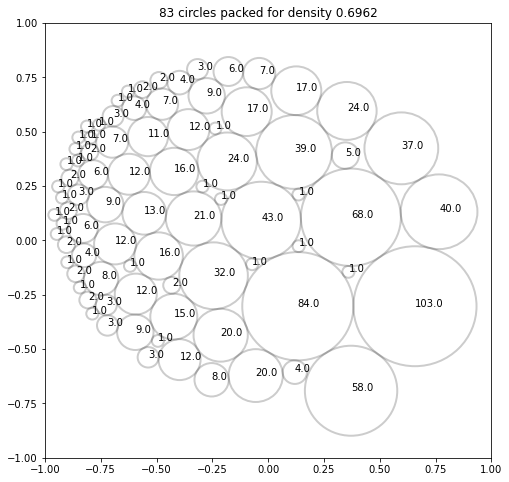

[Circle(x=-0.21140358913248306, y=0.190109594071161, r=0.02717227015224001, level=1, ex={'datum': 1.0}),
 Circle(x=-0.29441807267257963, y=0.24708595815784368, r=0.02717227015224001, level=1, ex={'datum': 1.0}),
 Circle(x=-0.07162970831974651, y=-0.10994867464161609, r=0.02717227015224001, level=1, ex={'datum': 1.0}),
 Circle(x=0.13663175933464183, y=-0.026743042980139926, r=0.02717227015224001, level=1, ex={'datum': 1.0}),
 Circle(x=0.1358502829063202, y=0.21066621759247256, r=0.02717227015224001, level=1, ex={'datum': 1.0}),
 Circle(x=-0.23607384082726343, y=0.5143734530952693, r=0.02717227015224001, level=1, ex={'datum': 1.0}),
 Circle(x=-0.6187444643022317, y=-0.11747248664991945, r=0.02717227015224001, level=1, ex={'datum': 1.0}),
 Circle(x=0.3595089268310026, y=-0.14482191877065917, r=0.02717227015224001, level=1, ex={'datum': 1.0}),
 Circle(x=-0.4939275514374655, y=-0.4624614753368631, r=0.02717227015224001, level=1, ex={'datum': 1.0}),
 Circle(x=-0.8436534451752062, y=-0.217095

In [912]:
import circlify as circ

foo = circ.circlify(
    np.round(data_dict['size'],2).tolist())

circ.bubbles(foo,lim=1)
data_dict['xpos'] = np.array([circle.x for circle in foo[::-1]])
data_dict['ypos'] = np.array([circle.y for circle in foo[::-1]])
foo


AttributeError: 'ListedColormap' object has no attribute 'vmin'

In [932]:
import plotly.graph_objects as go
from matplotlib.colors import Normalize,rgb2hex,LogNorm

cmap = plt.get_cmap('plasma')
norm = Normalize(vmin=np.min(data_dict['size']),vmax=np.max(data_dict['size']))
norm = LogNorm(vmin=np.min(data_dict['size']),vmax=np.max(data_dict['size']))

def bubble(data_dict,r=0.02717227015224001):
    fig = go.Figure()
    kwargs = {
        'type': 'circle',
        'xref': 'x',
        'yref': 'y',
        'layer':'above',
        'line':dict(
            color='gray')}

    ## add the actual bubbles to the figure
    points = [
        go.layout.Shape(
            x0=x-r*np.sqrt(count),x1=x+r*np.sqrt(count),
            y0=y-r*np.sqrt(count),y1=y+r*np.sqrt(count),
            fillcolor=rgb2hex(cmap(norm(count))[:-1]),
            **kwargs) 
        for x, y, count in zip(data_dict['xpos'],data_dict['ypos'],data_dict['size'])]
    fig.update_layout(shapes=points)

    ## add hover box using a scatter trace
    fig.add_trace(go.Scatter(
        x=data_dict['xpos'],
        y=data_dict['ypos'],
        mode="markers",
        hovertext=[
            f"{location}<br>{size:0.0f} recipients"
            for location,size in zip(data_dict['location'],data_dict['size'])
            ],
        marker=dict(color=None),
        hovertemplate='%{hovertext}<extra></extra>'
    ))

    ## setup the axis to be a blank (square) canvas
    fig.update_xaxes(range=[-1, 1])
    fig.update_yaxes(range=[-1, 1])

    fig.update_layout(
        width=600,
        height=600,
        margin=dict(
            t=0,b=0,
            l=0,r=0),
        xaxis={
            'showgrid': False, # thin lines in the background
            'zeroline': False, # thick line at x=0
            'visible': False},  # numbers below
        yaxis={
            'showgrid': False, # thin lines in the background
            'zeroline': False, # thick line at x=0
            'visible': False}  # numbers below
        )
    fig.update_traces(textposition='top center')
    return fig

fig = bubble(data_dict)
fig.show(
    #config={ 'modeBarButtonsToRemove': ['zoom', 'pan','select','lasso','autoscale','reset'] }
    config={'displayModeBar':False})

In [854]:
c.x

array([[-1.16995411e+01, -1.79995461e+01,  1.00000000e+00],
       [-1.45758203e+01, -1.46633415e+01,  1.00000000e+00],
       [-5.38945535e+00, -9.09689931e+00,  1.00000000e+00],
       [-1.82141182e+00, -1.09189105e+01,  1.00000000e+00],
       [-3.30252178e+00, -9.57491845e+00,  1.00000000e+00],
       [ 3.75255712e+00, -9.79183142e+00,  1.00000000e+00],
       [-2.57129507e-02, -1.00379245e+01,  1.00000000e+00],
       [-2.27673185e-01, -1.21273916e+01,  1.00000000e+00],
       [ 1.57250274e+00, -1.12554762e+01,  1.00000000e+00],
       [ 1.25014766e+01, -1.05689851e+01,  1.00000000e+00],
       [-1.25542699e+01, -1.61912720e+01,  1.00000000e+00],
       [-4.72327288e+00, -1.09826932e+01,  1.00000000e+00],
       [-1.50647740e+00, -8.69353604e+00,  1.00000000e+00],
       [-5.89819953e+00, -7.16257715e+00,  1.00000000e+00],
       [ 3.67898734e-01, -7.85378907e+00,  1.00000000e+00],
       [ 1.82153872e+00, -9.27101124e+00,  1.00000000e+00],
       [ 7.36352737e+00, -7.60046877e+00

In [852]:
data_dict['xpos'] = c.x[:,0]
data_dict['ypos'] = c.x[:,1]

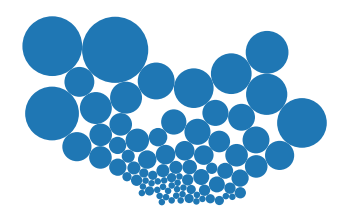

In [855]:
import numpy as np
import matplotlib.pyplot as plt

# create 10 circles with different radii
r = np.sqrt(data_dict['size'])#np.random.randint(5,15, size=10)

class C():
    def __init__(self,r):
        self.N = len(r)
        self.x = np.ones((self.N,3))
        self.x[:,2] = r
        maxstep = 2*self.x[:,2].max()
        length = np.ceil(np.sqrt(self.N))
        grid = np.arange(0,length*maxstep,maxstep)
        gx,gy = np.meshgrid(grid,grid)
        self.x[:,0] = gx.flatten()[:self.N]
        self.x[:,1] = gy.flatten()[:self.N]
        self.x[:,:2] = self.x[:,:2] - np.mean(self.x[:,:2], axis=0)

        self.step = self.x[:,2].min()
        self.p = lambda x,y: np.sum((x**2+y**2)**2)
        self.E = self.energy()
        self.iter = 1.

    def minimize(self):
        while self.iter < 1000:
            for i in range(self.N):
                rand = np.random.randn(2)*self.step/self.iter
                self.x[i,:2] += rand
                e = self.energy()
                if (e < self.E and self.isvalid(i)):
                    self.E = e
                    self.iter = 1.
                else:
                    self.x[i,:2] -= rand
                    self.iter += 1.

    def energy(self):
        return self.p(self.x[:,0], self.x[:,1])

    def distance(self,x1,x2):
        return np.sqrt((x1[0]-x2[0])**2+(x1[1]-x2[1])**2)-x1[2]-x2[2]

    def isvalid(self, i):
        for j in range(self.N):
            if i!=j: 
                if self.distance(self.x[i,:], self.x[j,:]) < 0:
                    return False
        return True

    def plot(self, ax):
        for i in range(self.N):
            circ = plt.Circle(self.x[i,:2],self.x[i,2] )
            ax.add_patch(circ)

c = C(r)

fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"))
ax.axis("off")

c.minimize()

c.plot(ax)
ax.relim()
ax.autoscale_view()
plt.show()

In [784]:
data_dict['xpos'].min()

-460.9685801497976

In [727]:
help(go.Scatter)

Help on class Scatter in module plotly.graph_objs._scatter:

class Scatter(plotly.basedatatypes.BaseTraceType)
 |  Scatter(arg=None, cliponaxis=None, connectgaps=None, customdata=None, customdatasrc=None, dx=None, dy=None, error_x=None, error_y=None, fill=None, fillcolor=None, groupnorm=None, hoverinfo=None, hoverinfosrc=None, hoverlabel=None, hoveron=None, hovertemplate=None, hovertemplatesrc=None, hovertext=None, hovertextsrc=None, ids=None, idssrc=None, legendgroup=None, legendgrouptitle=None, legendrank=None, line=None, marker=None, meta=None, metasrc=None, mode=None, name=None, opacity=None, orientation=None, selected=None, selectedpoints=None, showlegend=None, stackgaps=None, stackgroup=None, stream=None, text=None, textfont=None, textposition=None, textpositionsrc=None, textsrc=None, texttemplate=None, texttemplatesrc=None, uid=None, uirevision=None, unselected=None, visible=None, x=None, x0=None, xaxis=None, xcalendar=None, xhoverformat=None, xperiod=None, xperiod0=None, xperio

In [ ]:
go.

In [698]:
import plotly.graph_objects as go

help(go.layout.Shape)

Help on class Shape in module plotly.graph_objs.layout._shape:

class Shape(plotly.basedatatypes.BaseLayoutHierarchyType)
 |  Shape(arg=None, editable=None, fillcolor=None, fillrule=None, layer=None, line=None, name=None, opacity=None, path=None, templateitemname=None, type=None, visible=None, x0=None, x1=None, xanchor=None, xref=None, xsizemode=None, y0=None, y1=None, yanchor=None, yref=None, ysizemode=None, **kwargs)
 |  
 |  Method resolution order:
 |      Shape
 |      plotly.basedatatypes.BaseLayoutHierarchyType
 |      plotly.basedatatypes.BasePlotlyType
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, arg=None, editable=None, fillcolor=None, fillrule=None, layer=None, line=None, name=None, opacity=None, path=None, templateitemname=None, type=None, visible=None, x0=None, x1=None, xanchor=None, xref=None, xsizemode=None, y0=None, y1=None, yanchor=None, yref=None, ysizemode=None, **kwargs)
 |      Construct a new Shape object
 |      
 |      Paramete